In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from registration_utilities import *
from annotation_utilities import *
from metadata import *
from data_manager import *

/shared/MouseBrainAtlas/utilities/utilities2015.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python2.7/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python2.7/dist-pack

Setting environment for AWS compute node


No vtk


# Global

Directly using local is sufficient

In [125]:
# stack_fixed = 'LM30'
# stack_fixed = 'LM30new'
# stack_fixed = 'LM40'
stack_fixed = 'LM40new'
# stack_fixed = 'LM31'
# stack_fixed = 'LM38'
# stack_fixed = 'LM48'

stack_moving = 'atlasV5'

In [126]:
warp_setting = 24
# warp_setting = 16
# Adding surr is essential.

In [127]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [128]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = int(warp_properties['grad_computation_sample_number'])
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])
print std_tx, std_ty, std_tz, std_theta_xy

surround_weight = warp_properties['surround_weight']
if isinstance(surround_weight, float) or isinstance(surround_weight, int):
    surround_weight = float(surround_weight)
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
elif isinstance(surround_weight, str):
    surround_weight = str(surround_weight)
    # Setting surround_weight as inverse is very important. Using -1 often gives false peaks.
    include_surround = True
    
print surround_weight, include_surround

upstream_warp_id                                                               None
transform_type                                                               affine
terminate_thresh                                                                NaN
grad_computation_sample_number                                                10000
grid_search_sample_number                                                       NaN
std_tx_um                                                                      2000
std_ty_um                                                                      2000
std_tz_um                                                                      2000
std_theta_xy_degree                                                              30
surround_weight                                                             inverse
regularization_weight                                                           NaN
comment                           global reg with surr no grid search; count

In [129]:
MAX_ITER_NUM = 1000
HISTORY_LEN = 20
# MAX_GRID_SEARCH_ITER_NUM = 30

lr1 = 10
lr2 = 0.1

In [130]:
volume_moving, structure_to_label_moving, label_to_structure_moving = \
DataManager.load_original_volume_all_known_structures(stack=stack_moving, sided=True, volume_type='score', 
#                                                       include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])
print volume_moving[1].shape

Prior structure/index map not found. Generating a new one.


(356, 427, 375)


Volume shape: (356, 427, 375)


In [131]:
volume_fixed, structure_to_label_fixed, label_to_structure_fixed = \
DataManager.load_original_volume_all_known_structures(stack=stack_fixed, sided=True, 
                                                      volume_type='annotationAsScore',
                                                     include_surround=include_surround,
                                                     structures=['3N_L', 'RMC_L', 'SNR_L',
                                                                '3N_L_surround_200', 'RMC_L_surround_200', 'SNR_L_surround_200'])

print volume_fixed[1].shape

(163, 113, 182)


Prior structure/index map not found. Generating a new one.
Volume shape: (163, 113, 182)


In [132]:
structure_subset = all_known_structures_sided

In [133]:
if include_surround:
    structure_subset = structure_subset + [convert_to_surround_name(s, margin=200) for s in structure_subset]

In [134]:
label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()
                     if name_m in structure_subset and name_m in structure_to_label_fixed}

In [135]:
label_mapping_m2f

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [136]:
positive_weight = 'size'
# positive_weight = 'inverse'

In [137]:
cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()

In [138]:
label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

In [139]:
label_weights_m

{1: 1.0,
 2: 0.08578068878090006,
 3: 1.0,
 4: 0.15379052789032086,
 5: 1.0,
 6: 0.40870655618253604}

In [140]:
aligner = Aligner4(volume_fixed, volume_moving, labelIndexMap_m2f=label_mapping_m2f)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.


In [141]:
# aligner.set_centroid(centroid_m='origin', centroid_f='origin')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='centroid_m')
# aligner.set_centroid(centroid_m='volume_centroid', centroid_f='volume_centroid')
aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving['3N_L']])
# Sometimes initialize with SNR_L centers results in zero gradient. In those cases use another structure.

centroid_m: [  94.00685547  151.00359631  176.50280962], centroid_f: [  85.04047218   28.77133221  152.0698145 ]


In [142]:
aligner.set_label_weights(label_weights=label_weights_m)

In [143]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [144]:
gradient_filepath_map_f

{1: '/shared/CSHL_volumes/LM40new/LM40new_down32_annotationAsScoreVolume/score_volume_gradients/LM40new_down32_annotationAsScoreVolume_3N_L_%(suffix)s.bp',
 2: '/shared/CSHL_volumes/LM40new/LM40new_down32_annotationAsScoreVolume/score_volume_gradients/LM40new_down32_annotationAsScoreVolume_3N_L_surround_200_%(suffix)s.bp',
 3: '/shared/CSHL_volumes/LM40new/LM40new_down32_annotationAsScoreVolume/score_volume_gradients/LM40new_down32_annotationAsScoreVolume_RMC_L_%(suffix)s.bp',
 4: '/shared/CSHL_volumes/LM40new/LM40new_down32_annotationAsScoreVolume/score_volume_gradients/LM40new_down32_annotationAsScoreVolume_RMC_L_surround_200_%(suffix)s.bp',
 5: '/shared/CSHL_volumes/LM40new/LM40new_down32_annotationAsScoreVolume/score_volume_gradients/LM40new_down32_annotationAsScoreVolume_SNR_L_%(suffix)s.bp',
 6: '/shared/CSHL_volumes/LM40new/LM40new_down32_annotationAsScoreVolume/score_volume_gradients/LM40new_down32_annotationAsScoreVolume_SNR_L_surround_200_%(suffix)s.bp'}

In [145]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s-170 = 2 mins; all 28, 220s

indices_f: set([1, 2, 3, 4, 5, 6])
load gradient 1: 0.057512 seconds
load gradient 2: 0.058045 seconds
load gradient 3: 0.058365 seconds
load gradient 4: 0.060740 seconds
load gradient 5: 0.060926 seconds
load gradient 6: 0.064030 seconds
overall: 0.360225 seconds


In [146]:
# aligner.grid_search(10)

In [147]:
# Tuning learning rate:
# lr1=10., if lucky converges much faster than lr1=1., but sometimes stuck in local maxima
# If lr1=1., grad_computation_sample_number=1e5 is sufficient.

trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for _ in range(trial_num):

    try:
        T, scores = aligner.optimize(tf_type=transform_type, 
                                     max_iter_num=MAX_ITER_NUM,
#                                      max_iter_num=300,
                                     history_len=HISTORY_LEN, 
                                     terminate_thresh_rot=.002,
                                     terminate_thresh_trans=.2,
                                     grad_computation_sample_number=grad_computation_sample_number,
                                     lr1=lr1, lr2=lr2,
#                                     init_T=grid_search_T, 
#                                      affine_scaling_limits=(.9, 1.2)
                                    )
        T_all_trials.append(T)
        scores_all_trials.append(scores)
        traj_all_trials.append(aligner.Ts)
        
    except Exception as e:
        sys.stderr.write('%s\n' % e)


iteration 0
in T: 0.00 0.00 0.00, out T: 10.00 10.00 -10.00
step: 0.08 seconds
current score: -0.672094
new_T: [10. 10. -10.]
det: 1.10

iteration 1
in T: 10.00 10.00 -10.00, out T: 2.48 3.44 -3.21
step: 0.08 seconds
current score: -0.675689
new_T: [ 2.48164589  3.44457996 -3.21119136]
det: 1.08

iteration 2
in T: 2.48 3.44 -3.21, out T: 0.29 -2.02 4.49
step: 0.08 seconds
current score: -0.670669
new_T: [ 0.28956502 -2.0167735   4.49494852]
det: 0.96

iteration 3
in T: 0.29 -2.02 4.49, out T: 6.05 3.42 -2.08
step: 0.08 seconds
current score: -0.671879
new_T: [ 6.052566    3.41937505 -2.08454881]
det: 1.01

iteration 4
in T: 6.05 3.42 -2.08, out T: -1.55 -2.34 1.40
step: 0.08 seconds
current score: -0.670859
new_T: [-1.55403971 -2.34014032  1.40187933]
det: 0.99

iteration 5
in T: -1.55 -2.34 1.40, out T: 2.13 1.72 -2.48
step: 0.08 seconds
current score: -0.671850
new_T: [ 2.13284144  1.7169845  -2.47565632]
det: 1.03

iteration 6
in T: 2.13 1.72 -2.48, out T: 2.05 -0.33 1.50
step: 0.0

in T: 0.47 0.66 -0.45, out T: -0.52 0.73 -0.24
step: 0.09 seconds
current score: -0.669378
new_T: [-0.52366131  0.73409703 -0.24147438]
det: 0.97

iteration 54
in T: -0.52 0.73 -0.24, out T: -0.25 0.87 -0.52
step: 0.09 seconds
current score: -0.669434
new_T: [-0.24766222  0.86577787 -0.52349903]
det: 0.97

iteration 55
in T: -0.25 0.87 -0.52, out T: 0.55 0.06 -0.49
step: 0.09 seconds
current score: -0.669439
new_T: [ 0.54516005  0.05570236 -0.48972703]
det: 0.96

iteration 56
in T: 0.55 0.06 -0.49, out T: 0.61 0.77 -0.78
step: 0.09 seconds
current score: -0.669261
new_T: [ 0.61436878  0.77187233 -0.77919599]
det: 0.97

iteration 57
in T: 0.61 0.77 -0.78, out T: -0.46 0.19 0.29
step: 0.09 seconds
current score: -0.669490
new_T: [-0.46076641  0.19055579  0.28966096]
det: 0.97

iteration 58
in T: -0.46 0.19 0.29, out T: -0.23 1.15 -0.56
step: 0.09 seconds
current score: -0.669417
new_T: [-0.22572327  1.15497398 -0.55703928]
det: 0.99

iteration 59
in T: -0.23 1.15 -0.56, out T: -0.00 0.33

in T: -0.14 0.38 -0.33, out T: 0.32 0.47 -0.45
step: 0.09 seconds
current score: -0.669156
new_T: [ 0.31517231  0.46567788 -0.4521341 ]
det: 0.97

iteration 108
in T: 0.32 0.47 -0.45, out T: 0.50 0.93 -0.31
step: 0.08 seconds
current score: -0.669377
new_T: [ 0.49565356  0.92797524 -0.30614098]
det: 0.97

iteration 109
in T: 0.50 0.93 -0.31, out T: -0.42 0.31 0.07
step: 0.08 seconds
current score: -0.669348
new_T: [-0.42485007  0.30712636  0.07482963]
det: 0.96

iteration 110
in T: -0.42 0.31 0.07, out T: -0.58 0.92 -0.61
step: 0.09 seconds
current score: -0.669272
new_T: [-0.5798605   0.92055247 -0.60771906]
det: 0.97

iteration 111
in T: -0.58 0.92 -0.61, out T: -0.75 0.50 -0.05
step: 0.09 seconds
current score: -0.669350
new_T: [-0.75003305  0.50192642 -0.05257084]
det: 0.97

iteration 112
in T: -0.75 0.50 -0.05, out T: 0.34 1.07 -0.56
step: 0.09 seconds
current score: -0.669339
new_T: [ 0.34045566  1.06585799 -0.55882207]
det: 0.97

iteration 113
in T: 0.34 1.07 -0.56, out T: 0.19 

in T: -0.36 0.83 -0.53, out T: 0.20 0.59 -0.60
step: 0.09 seconds
current score: -0.669275
new_T: [ 0.20209191  0.59314055 -0.601524  ]
det: 0.96

iteration 159
in T: 0.20 0.59 -0.60, out T: -0.02 0.87 -0.55
step: 0.08 seconds
current score: -0.669201
new_T: [-0.01709011  0.87279275 -0.55131341]
det: 0.97

iteration 160
in T: -0.02 0.87 -0.55, out T: -0.21 0.43 0.34
step: 0.09 seconds
current score: -0.669121
new_T: [-0.20943789  0.42573353  0.33598776]
det: 0.96

iteration 161
in T: -0.21 0.43 0.34, out T: 0.91 1.08 0.06
step: 0.09 seconds
current score: -0.669346
new_T: [ 0.91046027  1.08299982  0.0639239 ]
det: 0.96

iteration 162
in T: 0.91 1.08 0.06, out T: 0.49 0.60 0.60
step: 0.09 seconds
current score: -0.669272
new_T: [ 0.49356275  0.60260082  0.59922892]
det: 0.96

iteration 163
in T: 0.49 0.60 0.60, out T: -0.04 1.00 -0.62
step: 0.08 seconds
current score: -0.669151
new_T: [-0.03694922  0.99813243 -0.61639405]
det: 0.98

iteration 164
in T: -0.04 1.00 -0.62, out T: 0.38 0.23

in T: 0.95 0.69 -0.55, out T: 0.96 0.65 -0.35
step: 0.08 seconds
current score: -0.669375
new_T: [ 0.96476724  0.64733574 -0.35320883]
det: 1.00

iteration 213
in T: 0.96 0.65 -0.35, out T: 1.19 0.78 -0.50
step: 0.08 seconds
current score: -0.669411
new_T: [ 1.19331615  0.77953804 -0.49944367]
det: 0.99

iteration 214
in T: 1.19 0.78 -0.50, out T: 0.58 0.35 -0.25
step: 0.08 seconds
current score: -0.669145
new_T: [ 0.57862433  0.34998505 -0.24650377]
det: 0.99

iteration 215
in T: 0.58 0.35 -0.25, out T: 0.13 1.02 -0.51
step: 0.09 seconds
current score: -0.669191
new_T: [ 0.12587865  1.02027058 -0.50704796]
det: 1.00

iteration 216
in T: 0.13 1.02 -0.51, out T: 0.68 0.50 -0.16
step: 0.08 seconds
current score: -0.669188
new_T: [ 0.68104453  0.49793152 -0.16228846]
det: 0.98

iteration 217
in T: 0.68 0.50 -0.16, out T: 1.47 0.83 -0.87
step: 0.08 seconds
current score: -0.669189
new_T: [ 1.46952153  0.82693372 -0.86593474]
det: 0.99

iteration 218
in T: 1.47 0.83 -0.87, out T: 0.20 -0.15

in T: 0.57 1.32 -0.84, out T: 0.14 0.22 0.35
step: 0.09 seconds
current score: -0.669325
new_T: [ 0.14442952  0.21512947  0.34636381]
det: 0.97

iteration 267
in T: 0.14 0.22 0.35, out T: 0.57 0.93 -0.51
step: 0.08 seconds
current score: -0.669294
new_T: [ 0.57067304  0.9299981  -0.50941197]
det: 0.98

iteration 268
in T: 0.57 0.93 -0.51, out T: -0.35 0.27 0.22
step: 0.09 seconds
current score: -0.669265
new_T: [-0.34987491  0.26540692  0.21733169]
det: 0.98

iteration 269
in T: -0.35 0.27 0.22, out T: 0.13 1.16 -0.51
step: 0.09 seconds
current score: -0.669326
new_T: [ 0.13431244  1.162968   -0.50956081]
det: 0.99

iteration 270
in T: 0.13 1.16 -0.51, out T: -0.19 0.45 -0.13
step: 0.09 seconds
current score: -0.669275
new_T: [-0.19184505  0.44912106 -0.12576576]
det: 0.98

iteration 271
in T: -0.19 0.45 -0.13, out T: 0.11 1.23 -0.87
step: 0.08 seconds
current score: -0.669226
new_T: [ 0.11168027  1.23224983 -0.86938237]
det: 0.99

iteration 272
in T: 0.11 1.23 -0.87, out T: -0.26 0.13

in T: 0.11 0.96 -0.42, out T: 0.25 0.40 -0.02
step: 0.09 seconds
current score: -0.669134
new_T: [ 0.24588893  0.39663355 -0.02448019]
det: 0.96

iteration 321
in T: 0.25 0.40 -0.02, out T: -0.02 0.84 -0.22
step: 0.08 seconds
current score: -0.669188
new_T: [-0.01562687  0.8370984  -0.22049759]
det: 0.97

iteration 322
in T: -0.02 0.84 -0.22, out T: -0.24 0.64 0.09
step: 0.08 seconds
current score: -0.669174
new_T: [-0.23689557  0.63930667  0.08857526]
det: 0.96

iteration 323
in T: -0.24 0.64 0.09, out T: -0.50 0.68 -0.34
step: 0.09 seconds
current score: -0.669054
new_T: [-0.49697414  0.68230166 -0.34445244]
det: 0.97

iteration 324
in T: -0.50 0.68 -0.34, out T: 0.03 0.55 -0.37
step: 0.08 seconds
current score: -0.669121
new_T: [ 0.02909154  0.54893918 -0.36535871]
det: 0.96

iteration 325
in T: 0.03 0.55 -0.37, out T: -0.48 0.42 -0.04
step: 0.08 seconds
current score: -0.669102
new_T: [-0.47583598  0.42152523 -0.03731214]
det: 0.96

iteration 326
in T: -0.48 0.42 -0.04, out T: -0.0

in T: -0.24 0.75 -0.52, out T: -0.54 0.69 -0.40
step: 0.09 seconds
current score: -0.669117
new_T: [-0.5378487   0.69181104 -0.39929741]
det: 0.96

iteration 372
in T: -0.54 0.69 -0.40, out T: -0.49 0.78 -0.32
step: 0.08 seconds
current score: -0.669100
new_T: [-0.49320289  0.77655668 -0.32007846]
det: 0.96

iteration 373
in T: -0.49 0.78 -0.32, out T: -0.24 0.86 -0.66
step: 0.09 seconds
current score: -0.669111
new_T: [-0.24118991  0.85765273 -0.66170425]
det: 0.95

iteration 374
in T: -0.24 0.86 -0.66, out T: -0.21 0.94 -0.13
step: 0.09 seconds
current score: -0.669074
new_T: [-0.21165555  0.93516048 -0.12683623]
det: 0.95

iteration 375
in T: -0.21 0.94 -0.13, out T: -0.53 0.93 -0.17
step: 0.09 seconds
current score: -0.668967
new_T: [-0.52943774  0.93180575 -0.16921621]
det: 0.96

iteration 376
in T: -0.53 0.93 -0.17, out T: 0.01 0.84 -0.32
step: 0.09 seconds
current score: -0.669033
new_T: [ 0.00653148  0.8423484  -0.32038381]
det: 0.96

iteration 377
in T: 0.01 0.84 -0.32, out T:

in T: 0.69 1.14 -0.70, out T: -0.11 0.34 0.09
step: 0.09 seconds
current score: -0.669162
new_T: [-0.10602889  0.33939526  0.09399591]
det: 0.97

iteration 423
in T: -0.11 0.34 0.09, out T: 0.12 1.10 -0.66
step: 0.08 seconds
current score: -0.669160
new_T: [ 0.12325662  1.09604536 -0.65945517]
det: 0.98

iteration 424
in T: 0.12 1.10 -0.66, out T: 0.17 0.43 0.05
step: 0.08 seconds
current score: -0.669180
new_T: [ 0.17239474  0.42508754  0.04793237]
det: 0.96

iteration 425
in T: 0.17 0.43 0.05, out T: 0.31 1.24 -0.86
step: 0.09 seconds
current score: -0.669117
new_T: [ 0.30588338  1.24385536 -0.85653571]
det: 0.98

iteration 426
in T: 0.31 1.24 -0.86, out T: -0.11 0.31 0.03
step: 0.08 seconds
current score: -0.669304
new_T: [-0.11279073  0.30687702  0.03297777]
det: 0.97

iteration 427
in T: -0.11 0.31 0.03, out T: 0.41 0.96 -0.56
step: 0.09 seconds
current score: -0.669189
new_T: [ 0.41477088  0.958279   -0.55513861]
det: 0.97

iteration 428
in T: 0.41 0.96 -0.56, out T: 0.59 0.65 -0

in T: 0.26 0.65 -0.53, out T: 0.40 0.66 -0.49
step: 0.09 seconds
current score: -0.669048
new_T: [ 0.40121778  0.65957325 -0.48568988]
det: 0.95

iteration 477
in T: 0.40 0.66 -0.49, out T: -0.40 0.80 -0.53
step: 0.09 seconds
current score: -0.669072
new_T: [-0.40065767  0.79636328 -0.53414981]
det: 0.96

iteration 478
in T: -0.40 0.80 -0.53, out T: -0.04 0.59 -0.64
step: 0.09 seconds
current score: -0.669145
new_T: [-0.0365253   0.58669259 -0.63589559]
det: 0.95

iteration 479
in T: -0.04 0.59 -0.64, out T: 0.08 0.41 -0.39
step: 0.09 seconds
current score: -0.669050
new_T: [ 0.0840941   0.41132644 -0.39076361]
det: 0.95

iteration 480
in T: 0.08 0.41 -0.39, out T: -0.02 0.64 -0.34
step: 0.08 seconds
current score: -0.669031
new_T: [-0.02457001  0.63672727 -0.34270016]
det: 0.95

iteration 481
in T: -0.02 0.64 -0.34, out T: -0.20 0.56 -0.37
step: 0.09 seconds
current score: -0.669034
new_T: [-0.20226591  0.556413   -0.37145403]
det: 0.95

iteration 482
in T: -0.20 0.56 -0.37, out T: 0.

in T: -0.75 0.29 -0.23, out T: -0.44 0.56 -0.27
step: 0.09 seconds
current score: -0.669021
new_T: [-0.43535457  0.55841491 -0.27141121]
det: 0.95

iteration 528
in T: -0.44 0.56 -0.27, out T: 0.07 0.69 -0.05
step: 0.09 seconds
current score: -0.669056
new_T: [ 0.07498529  0.69337839 -0.05238626]
det: 0.94

iteration 529
in T: 0.07 0.69 -0.05, out T: -0.18 0.40 -0.10
step: 0.09 seconds
current score: -0.669016
new_T: [-0.17871484  0.39561461 -0.10112719]
det: 0.94

iteration 530
in T: -0.18 0.40 -0.10, out T: -0.30 0.71 -0.41
step: 0.09 seconds
current score: -0.669039
new_T: [-0.30125574  0.71042303 -0.41190392]
det: 0.95

iteration 531
in T: -0.30 0.71 -0.41, out T: -0.57 0.50 0.03
step: 0.09 seconds
current score: -0.669089
new_T: [-0.57005857  0.5042732   0.03060353]
det: 0.94

iteration 532
in T: -0.57 0.50 0.03, out T: -0.49 0.73 -0.53
step: 0.09 seconds
current score: -0.669125
new_T: [-0.49462501  0.73329309 -0.52753343]
det: 0.95

iteration 533
in T: -0.49 0.73 -0.53, out T: -

in T: -0.11 0.75 -0.67, out T: -0.06 0.57 -0.32
step: 0.09 seconds
current score: -0.669097
new_T: [-0.06384606  0.56949153 -0.322313  ]
det: 0.94

iteration 579
in T: -0.06 0.57 -0.32, out T: 0.18 0.96 -0.63
step: 0.09 seconds
current score: -0.669077
new_T: [ 0.18371912  0.95605381 -0.63288375]
det: 0.94

iteration 580
in T: 0.18 0.96 -0.63, out T: -0.28 0.73 -0.31
step: 0.09 seconds
current score: -0.669103
new_T: [-0.28043508  0.73475743 -0.31481275]
det: 0.95

iteration 581
in T: -0.28 0.73 -0.31, out T: -0.27 1.00 -0.72
step: 0.09 seconds
current score: -0.669042
new_T: [-0.26843238  1.00149106 -0.71808728]
det: 0.95

iteration 582
in T: -0.27 1.00 -0.72, out T: -0.32 0.34 -0.15
step: 0.09 seconds
current score: -0.669011
new_T: [-0.31726124  0.33585635 -0.14739021]
det: 0.94

iteration 583
in T: -0.32 0.34 -0.15, out T: -0.29 0.84 -0.61
step: 0.09 seconds
current score: -0.669053
new_T: [-0.28619342  0.84428528 -0.60884364]
det: 0.95

iteration 584
in T: -0.29 0.84 -0.61, out T:

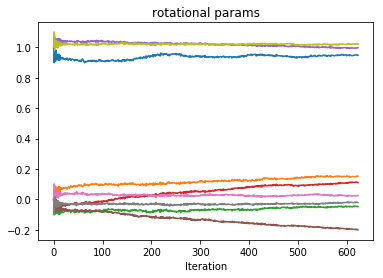

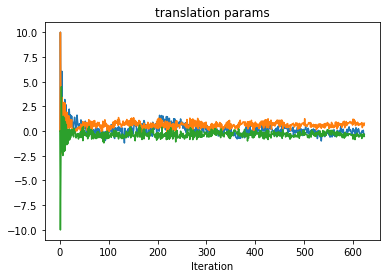

In [148]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,1,2,4,5,6,8,9,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
-0.668922113971 -0.668988440599
[[ 0.9360632   0.14660021 -0.05099449  0.0697386 ]
 [ 0.09532453  1.00190201 -0.17764635  0.39272524]
 [ 0.0293865  -0.02715957  1.01754352 -0.28863407]]


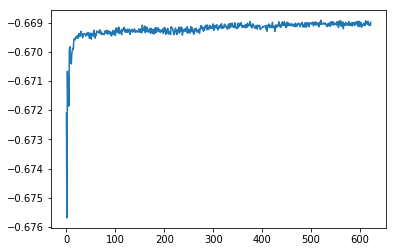

In [149]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

In [150]:
# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (affine_components_to_vector(-9.77304587,  48.73149657,  -2.80149108,  -0.16628751), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,130,0,1,0,-70,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (grid_search_T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(T, 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# global_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (np.array([1,0,0,0,0,1,0,0,0,0,1,0]), 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [151]:
structure = 'SNR_L'

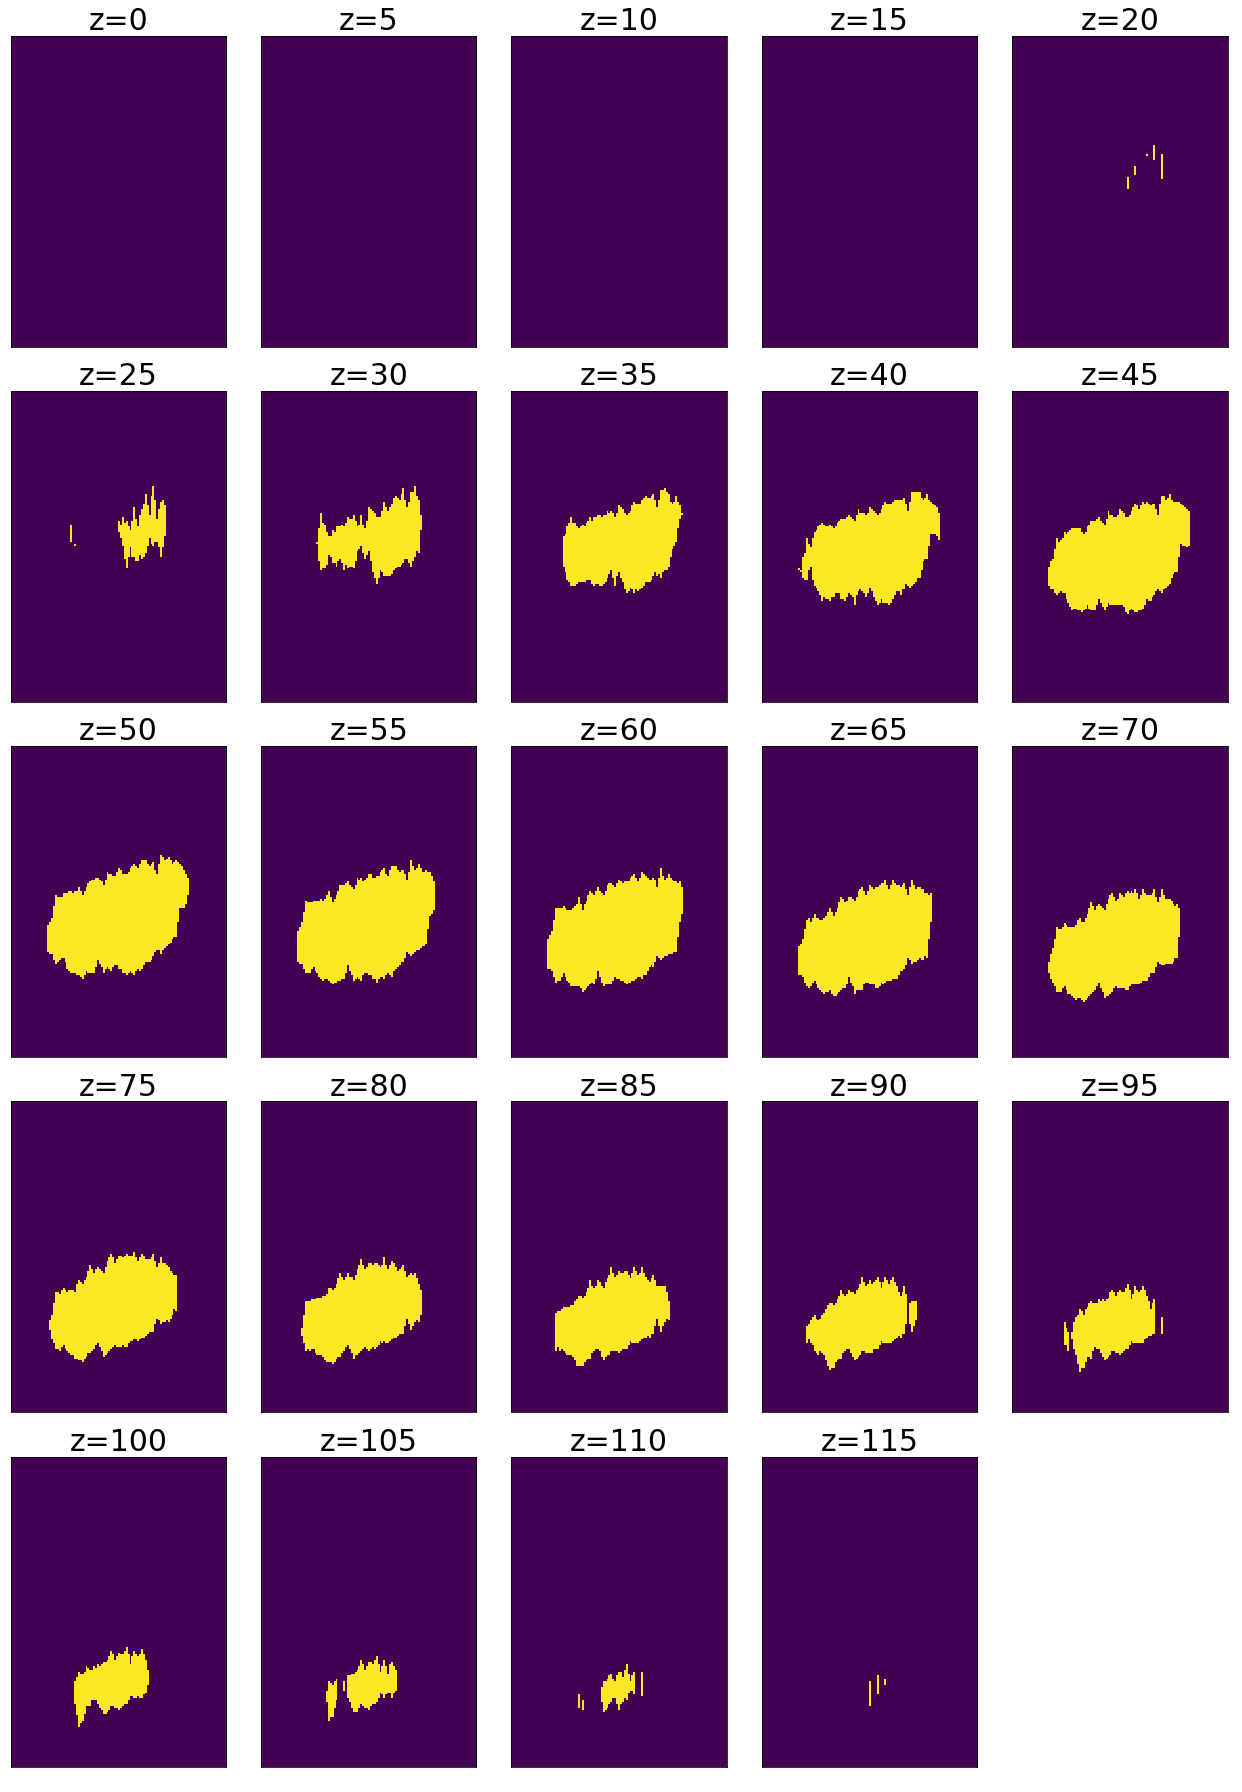

In [152]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0)

In [153]:
# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

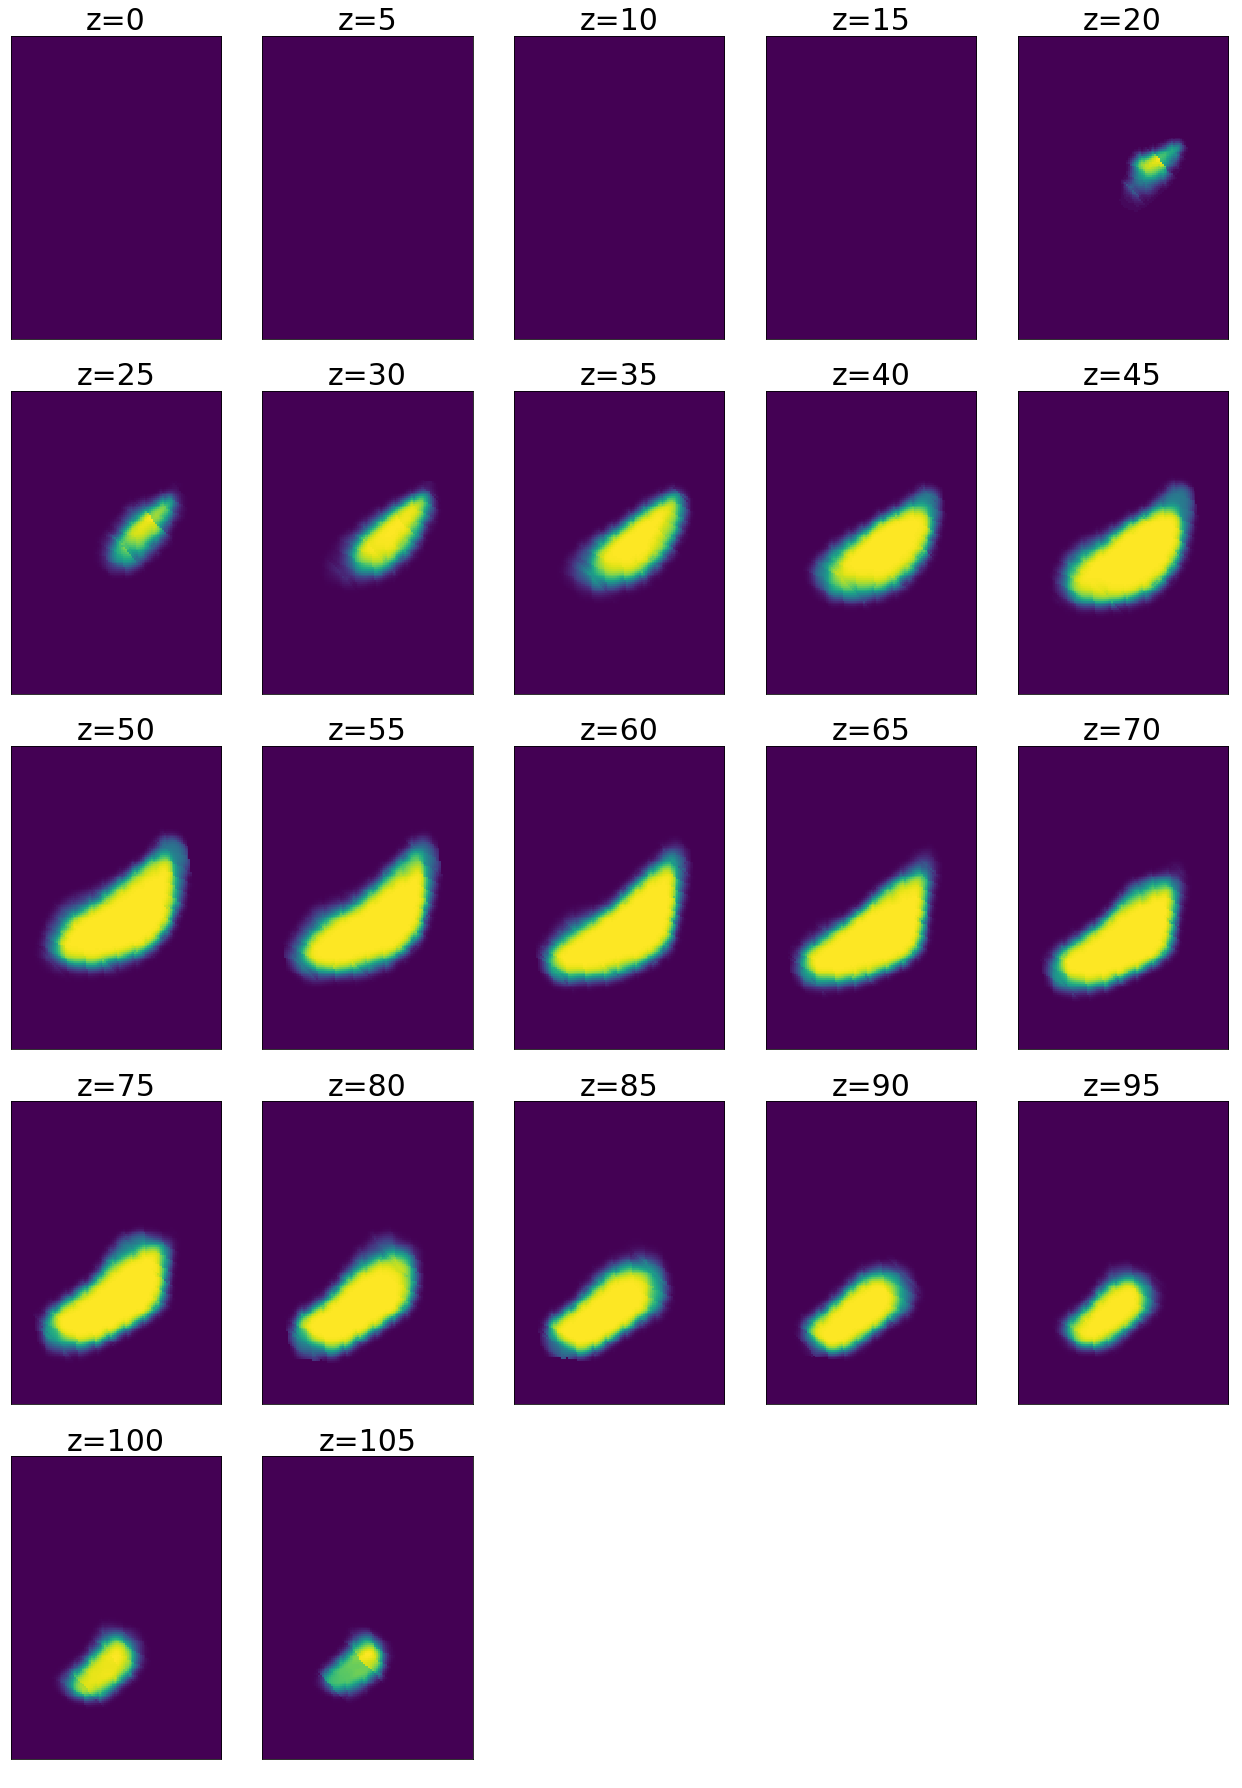

In [154]:
v_m2f = \
crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                    out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

display_volume_sections(v_m2f, start_level=0)

In [155]:
# Warping all structures.

volume_m2f = {}
for label_m, vol_m in volume_moving.iteritems():
    
    volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
    transform_volume_v2(vol=vol_m, tf_params=global_params, centroid_m=centroid_m, centroid_f=centroid_f)

    volume_m2f[label_m] = crop_and_pad_volume(volume_m_alignedTo_f, in_bbox=volume_m_alignedTo_f_bbox,
                        out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1))

In [156]:
def draw_alignment(warped_atlas, fixed_volumes, level_spacing=10, zs=None, ncols=5):
    """
    """
    
    ydim_f, xdim_f, zdim_f = fixed_volumes.values()[0].shape
    
    aspect_ratio = float(xdim_f)/ydim_f # width / height
    
    if zs is None:
        zs = np.arange(0, zdim, level_spacing)
    n = len(zs)

    nrows = int(np.ceil(len(zs) / float(ncols)))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, squeeze=True, 
                             figsize=(ncols*5*aspect_ratio, nrows*5))
    axes = axes.flatten()
    
    for zi in range(len(axes)):
        if zi >= n:
            axes[zi].axis('off');
        else:        
            z = zs[zi]
            viz = np.zeros((ydim_f, xdim_f, 3), np.uint8)

            for l in volume_fixed.keys():
                if is_surround_label(label_to_structure_fixed[l]): 
                    continue
                zslice = volume_fixed[l][..., z]
                contours = find_contour_points(zslice)
                if len(contours) == 0:
                    continue
                    
                for cnt in contours[1]:
                    cv2.polylines(viz, pts=[cnt.astype(np.int)], isClosed=True, 
                              thickness=1,
                              color=name_unsided_to_color[convert_to_original_name(label_to_structure_fixed[l])])

            cutoff_level = 0.5

            for l in warped_atlas.keys():
                if is_surround_label(label_to_structure_moving[l]): 
                    continue
                zslice = warped_atlas[l][..., z]
                contours = find_contour_points(zslice > cutoff_level)
                if len(contours) == 0:
                    continue
                
                for cnt in contours[1]:
                    cv2.polylines(viz, pts=[cnt.astype(np.int)], isClosed=True,
                              thickness=1,
                             color=name_unsided_to_color[convert_to_original_name(label_to_structure_moving[l])])        

            axes[zi].imshow(viz)
            axes[zi].set_title("z=%d" % z)
            axes[zi].set_xticks([]);
            axes[zi].set_yticks([]);
        
    plt.show()

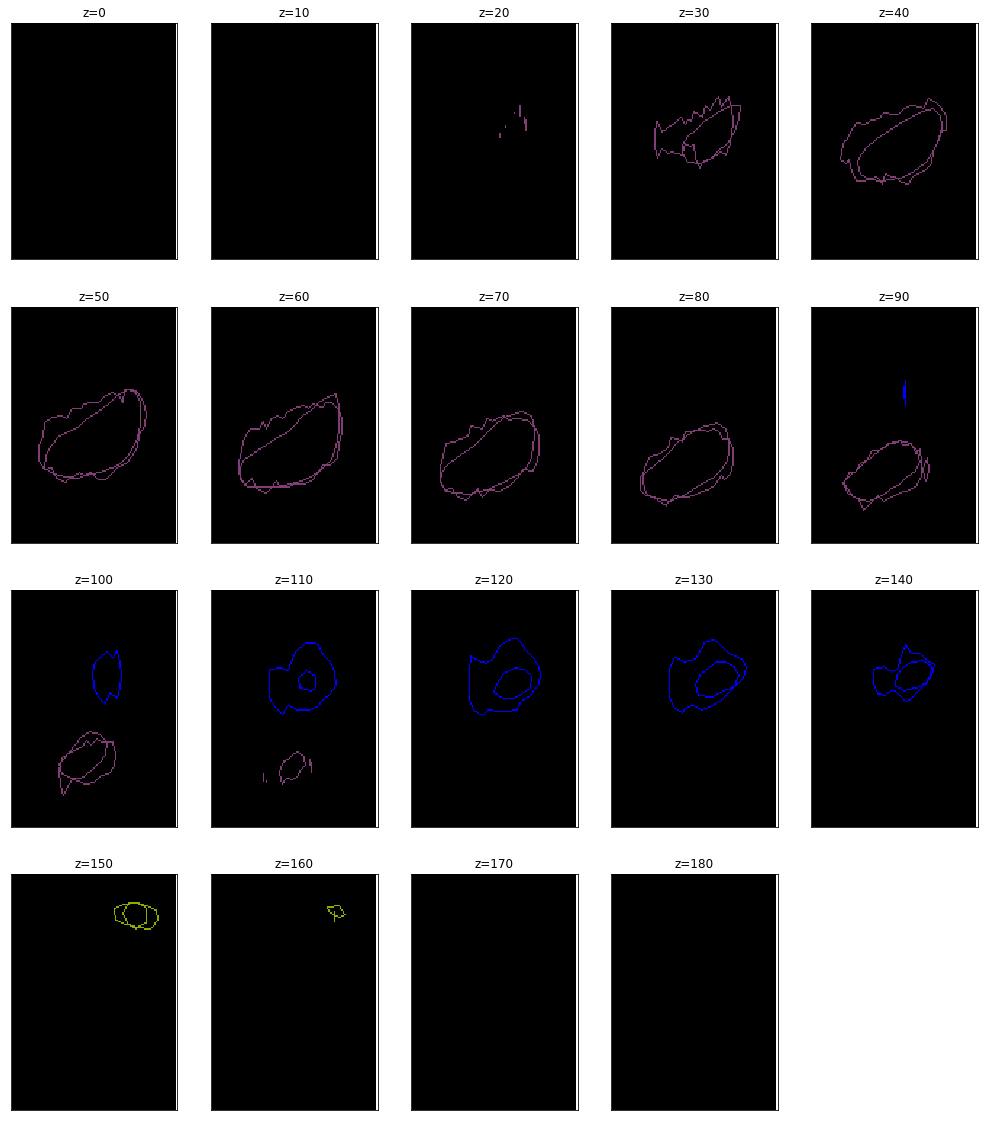

In [157]:
draw_alignment(warped_atlas=volume_m2f, fixed_volumes=volume_fixed, zs=np.arange(0,190,10), ncols=5)

In [158]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume/atlasV5_down32_scoreVolume_warp24_LM40new_down32_scoreVolume_scoreEvolution.png" "s3://mo

# Local

warp setting = 16 means directly rigidly register SNR_L with atlas SNR_L, taking surround into consideration.

In [63]:
registration_settings = read_csv(REGISTRATION_SETTINGS_CSV, header=0, index_col=0)
registration_settings

,upstream_warp_id,transform_type,terminate_thresh,grad_computation_sample_number,grid_search_sample_number,std_tx_um,std_ty_um,std_tz_um,std_theta_xy_degree,surround_weight,regularization_weight,comment,max_iter_num
warp_id,,,,,,,,,,,,,
1,None,affine,0.000010,100000.0,1000.0,2000.0,2000.0,2000.0,30.0,0,NaN,NaN,NaN
2,1,rigid,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN
4,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,10.0,0,0.000001,NaN,NaN
5,1,rigid,0.000001,100000.0,10000.0,100.0,100.0,100.0,30.0,inverse,0.000000,NaN,NaN
6,1,affine,0.000010,100000.0,10000.0,100.0,100.0,100.0,30.0,-0.5,0.000000,NaN,NaN
7,None,rigid,0.000001,100000.0,1000.0,50.0,50.0,50.0,10.0,0,NaN,NaN,NaN
8,None,rigid,0.000001,100000.0,10000.0,200.0,200.0,200.0,30.0,inverse,0.000000,align mid-sagittal planes,NaN
9,8,rigid,0.000001,100000.0,10000.0,2000.0,2000.0,2000.0,30.0,NaN,NaN,global registration given mid-sagittal planes ...,NaN
10,None,rigid,0.000010,100000.0,1000.0,100.0,100.0,100.0,30.0,0,NaN,NaN,NaN


In [64]:
# stack_fixed = 'LM30new'
stack_fixed = 'LM40new'
# stack_fixed = 'LM30'
# stack_fixed = 'LM40'
stack_moving = 'atlasV5'

In [65]:
warp_setting = 22

In [66]:
warp_properties = registration_settings.loc[warp_setting]
print warp_properties

upstream_warp_setting = warp_properties['upstream_warp_id']
if upstream_warp_setting == 'None':
    upstream_warp_setting = None
else:
    upstream_warp_setting = int(upstream_warp_setting)
    
transform_type = warp_properties['transform_type']
terminate_thresh = warp_properties['terminate_thresh']
grad_computation_sample_number = warp_properties['grad_computation_sample_number']
grid_search_sample_number = warp_properties['grid_search_sample_number']
std_tx_um = warp_properties['std_tx_um']
std_ty_um = warp_properties['std_ty_um']
std_tz_um = warp_properties['std_tz_um']
std_tx = std_tx_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_ty = std_ty_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_tz = std_tz_um/(XY_PIXEL_DISTANCE_LOSSLESS*32)
std_theta_xy = np.deg2rad(warp_properties['std_theta_xy_degree'])

try:
    surround_weight = float(warp_properties['surround_weight'])
    include_surround = surround_weight != 0 and not np.isnan(surround_weight)
except:
    surround_weight = str(warp_properties['surround_weight'])
    include_surround = True

reg_weight = warp_properties['regularization_weight']
if np.isnan(reg_weight):
    reg_weights = np.zeros((3,))
else:
    reg_weights = np.ones((3,))*reg_weight

print
print 'std', std_tx, std_ty, std_tz, std_theta_xy
print 'surround', surround_weight
print 'regularization', reg_weights

upstream_warp_id                                        None
transform_type                                         rigid
terminate_thresh                                         NaN
grad_computation_sample_number                        100000
grid_search_sample_number                              10000
std_tx_um                                                200
std_ty_um                                                200
std_tz_um                                                200
std_theta_xy_degree                                       30
surround_weight                                      inverse
regularization_weight                                      0
comment                           global reg rigid with surr
max_iter_num                                             NaN
Name: 22, dtype: object

std 13.5869565217 13.5869565217 13.5869565217 0.523598775598
surround inverse
regularization [ 0.  0.  0.]


In [67]:
MAX_ITER_NUM = 10000
HISTORY_LEN = 200
MAX_GRID_SEARCH_ITER_NUM = 30

In [68]:
lr1 = 10
lr2 = 0.1

In [69]:
structure = 'SNR_L'

In [70]:
if include_surround:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')], volume_type='annotationAsScore')
else:
    volume_fixed, structure_to_label_fixed, label_to_structure_fixed = DataManager.load_original_volume_all_known_structures(stack=stack_fixed, 
                                                                 structures=[structure], volume_type='annotationAsScore')
# This loads the internal/inside-bbox volume.
# So registration is done with respect to this.
# Need to take into account the actual bbox when converting points.

Prior structure/index map not found. Generating a new one.
Volume shape: (163, 113, 182)


In [71]:
print DataManager.load_original_volume_bbox(stack=stack_fixed, structure='SNR_L', volume_type='annotationAsScore')

[ -19   93 1133 1295 5918 6099]


In [72]:
if include_surround:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                structures=[structure, convert_to_surround_name(structure, margin='200')])
else:
    volume_moving, structure_to_label_moving, label_to_structure_moving = DataManager.load_original_volume_all_known_structures(stack=stack_moving, 
                                                                 structures=[structure])

# structure_to_label_moving = {s: l+1 for l, s in enumerate(sorted(volume_moving.keys()))}
# label_to_structure_moving = {l+1: s for l, s in enumerate(sorted(volume_moving.keys()))}
# volume_moving = {structure_to_label_moving[s]: v for s, v in volume_moving.items()}

label_mapping_m2f = {label_m: structure_to_label_fixed[name_m] 
                     for label_m, name_m in label_to_structure_moving.iteritems()}

cutoff = .5 # Structure size is defined as the number of voxels whose value is above this cutoff probability.
pool = Pool(NUM_CORES)
volume_moving_structure_sizes = dict(zip(volume_moving.keys(), 
                                         pool.map(lambda l: np.count_nonzero(volume_moving[l] > cutoff), 
                                                  volume_moving.keys())))
pool.close()
pool.join()


positive_weight = 'size'
# positive_weight = 'inverse'

label_weights_m = {}

for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if not is_surround_label(name_m):
        if positive_weight == 'size':
            label_weights_m[label_m] = 1.
        elif positive_weight == 'inverse':
            p = np.percentile(volume_moving_structure_sizes.values(), 50)
            label_weights_m[label_m] =  np.minimum(p / volume_moving_structure_sizes[label_m], 1.)
        else:
            sys.stderr.write("positive_weight %s is not recognized. Using the default.\n" % positive_weight)
            
for label_m in label_mapping_m2f.iterkeys():
    name_m = label_to_structure_moving[label_m]
    if is_surround_label(name_m):
        label_ns = structure_to_label_moving[convert_to_nonsurround_name(name_m)]
        if surround_weight == 'inverse':
            # Note that this is positive; in regular, surround is negative
#             label_weights_m[label_m] = - label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
            label_weights_m[label_m] = label_weights_m[label_ns] * volume_moving_structure_sizes[label_ns]/float(volume_moving_structure_sizes[label_m])
        elif isinstance(surround_weight, int) or isinstance(surround_weight, float):
            label_weights_m[label_m] = surround_weight
        else:
            sys.stderr.write("surround_weight %s is not recognized. Using the default.\n" % surround_weight)

Prior structure/index map not found. Generating a new one.
Volume shape: (356, 427, 375)


In [73]:
label_weights_m

{1: 1.0, 2: 0.40870655618253604}

In [74]:
aligner = Aligner4(volume_fixed, volume_moving, 
                   labelIndexMap_m2f=label_mapping_m2f)

aligner.set_centroid(centroid_m='structure_centroid', centroid_f='structure_centroid', 
                     indices_m=[structure_to_label_moving[structure]])

aligner.set_regularization_weights(reg_weights)
aligner.set_label_weights(label_weights_m)

Label weights not set, default to 1 for all structures.
Regularization weights not set, default to 0.
centroid_m: [  50.43135167  207.82499502   91.38163608], centroid_f: [ 55.11165633  97.61789349  62.03171572]


In [75]:
# grid_search_T, grid_search_score = aligner.do_grid_search(grid_search_iteration_number=MAX_GRID_SEARCH_ITER_NUM, 
#                grid_search_sample_number=8,
#               std_tx=std_tx, std_ty=std_ty, std_tz=std_tz, std_theta_xy=0,
#                grid_search_eta=3., stop_radius_voxel=3)

In [76]:
gradient_filepath_map_f = \
{ind_f: DataManager.get_volume_gradient_filepath_template(\
                                                          stack=stack_fixed, 
                                                          structure=label_to_structure_fixed[ind_f],
                                                         volume_type='annotationAsScore')
 for ind_m, ind_f in label_mapping_m2f.iteritems()}

In [79]:
aligner.load_gradient(gradient_filepath_map_f=gradient_filepath_map_f) # 120s = 2 mins

indices_f: set([1, 2])
load gradient 1: 0.063736 seconds
load gradient 2: 0.065711 seconds
overall: 0.129571 seconds


In [80]:
trial_num = 1

T_all_trials = []
scores_all_trials = []
traj_all_trials = []

for trial_idx in range(trial_num):

    T, scores = aligner.optimize(tf_type=transform_type, 
                                 max_iter_num=MAX_ITER_NUM, 
                                 history_len=HISTORY_LEN, 
#                                  grad_computation_sample_number=int(grad_computation_sample_number),
                                 lr1=1, lr2=1e-2, 
                                 terminate_thresh_trans=0.5, terminate_thresh_rot=0.001)
#                                  init_T=grid_search_T)

#         print T.reshape((3,4))
#         plt.figure();
#         plt.plot(scores);
#         plt.show();
#         print max(scores), scores[-1]

    T_all_trials.append(T)
    scores_all_trials.append(scores)
    traj_all_trials.append(np.array(aligner.Ts))


iteration 0
step: 0.25 seconds
current score: 0.222423
new_T: [ 0.99993333 -1.00996642  0.98996692]
det: 1.00

iteration 1
step: 0.24 seconds
current score: 0.223749
new_T: [ 1.36760808 -0.59689     0.01274399]
det: 1.00

iteration 2
step: 0.24 seconds
current score: 0.224014
new_T: [ 0.94010117 -1.38053902  0.04385762]
det: 1.00

iteration 3
step: 0.24 seconds
current score: 0.225569
new_T: [ 1.27264981 -1.3294489  -0.31655988]
det: 1.00

iteration 4
step: 0.24 seconds
current score: 0.226181
new_T: [ 1.27269428 -1.58495496 -0.34799457]
det: 1.00

iteration 5
step: 0.24 seconds
current score: 0.226255
new_T: [ 1.42494315 -1.58323812 -0.53271219]
det: 1.00

iteration 6
step: 0.24 seconds
current score: 0.226711
new_T: [ 1.37282612 -1.70671172 -0.56647125]
det: 1.00

iteration 7
step: 0.24 seconds
current score: 0.227201
new_T: [ 1.45983989 -1.73845746 -0.6174907 ]
det: 1.00

iteration 8
step: 0.24 seconds
current score: 0.227562
new_T: [ 1.45719836 -1.77340099 -0.62341331]
det: 1.00



step: 0.24 seconds
current score: 0.234720
new_T: [ 1.3938494  -0.70810851  0.45493499]
det: 1.00

iteration 74
step: 0.24 seconds
current score: 0.234770
new_T: [ 1.36655028 -0.72193428  0.46747611]
det: 1.00

iteration 75
step: 0.24 seconds
current score: 0.234809
new_T: [ 1.37786452 -0.70803918  0.46471169]
det: 1.00

iteration 76
step: 0.24 seconds
current score: 0.234865
new_T: [ 1.37128587 -0.71908232  0.47682875]
det: 1.00

iteration 77
step: 0.24 seconds
current score: 0.234899
new_T: [ 1.38386907 -0.70333571  0.47030482]
det: 1.00

iteration 78
step: 0.24 seconds
current score: 0.234941
new_T: [ 1.37000088 -0.70468573  0.46869512]
det: 1.00

iteration 79
step: 0.24 seconds
current score: 0.234993
new_T: [ 1.37889483 -0.70003017  0.47295652]
det: 1.00

iteration 80
step: 0.24 seconds
current score: 0.235027
new_T: [ 1.36716893 -0.70552041  0.47326617]
det: 1.00

iteration 81
step: 0.24 seconds
current score: 0.235060
new_T: [ 1.37075391 -0.69493809  0.47277394]
det: 1.00

itera

step: 0.24 seconds
current score: 0.236737
new_T: [ 1.30487694 -0.66914999  0.62150866]
det: 1.00

iteration 147
step: 0.24 seconds
current score: 0.236744
new_T: [ 1.29553628 -0.65103432  0.61753281]
det: 1.00

iteration 148
step: 0.24 seconds
current score: 0.236750
new_T: [ 1.30040049 -0.66073529  0.63612589]
det: 1.00

iteration 149
step: 0.24 seconds
current score: 0.236785
new_T: [ 1.28601827 -0.65207972  0.63075252]
det: 1.00

iteration 150
step: 0.24 seconds
current score: 0.236795
new_T: [ 1.29758902 -0.65216016  0.6338971 ]
det: 1.00

iteration 151
step: 0.24 seconds
current score: 0.236809
new_T: [ 1.29596173 -0.65682067  0.64540445]
det: 1.00

iteration 152
step: 0.24 seconds
current score: 0.236825
new_T: [ 1.28201663 -0.65488316  0.64304434]
det: 1.00

iteration 153
step: 0.24 seconds
current score: 0.236846
new_T: [ 1.29128321 -0.64736527  0.64199289]
det: 1.00

iteration 154
step: 0.24 seconds
current score: 0.236866
new_T: [ 1.27400585 -0.65063021  0.65390628]
det: 1.0

step: 0.24 seconds
current score: 0.237638
new_T: [ 1.24802518 -0.74572341  0.66556957]
det: 1.00

iteration 220
step: 0.24 seconds
current score: 0.237651
new_T: [ 1.24879427 -0.74817569  0.6685568 ]
det: 1.00

iteration 221
step: 0.24 seconds
current score: 0.237653
new_T: [ 1.25354169 -0.75127492  0.67140169]
det: 1.00

iteration 222
step: 0.24 seconds
current score: 0.237651
new_T: [ 1.24760929 -0.7529262   0.67310992]
det: 1.00

iteration 223
step: 0.24 seconds
current score: 0.237662
new_T: [ 1.24839657 -0.75431684  0.67869684]
det: 1.00

iteration 224
step: 0.24 seconds
current score: 0.237673
new_T: [ 1.22822424 -0.75932203  0.67965289]
det: 1.00

iteration 225
step: 0.24 seconds
current score: 0.237668
new_T: [ 1.23679773 -0.73890327  0.68741007]
det: 1.00

iteration 226
step: 0.24 seconds
current score: 0.237683
new_T: [ 1.22237903 -0.74323461  0.69909527]
det: 1.00

iteration 227
step: 0.24 seconds
current score: 0.237703
new_T: [ 1.22907953 -0.74314714  0.70196638]
det: 1.0

step: 0.24 seconds
current score: 0.238153
new_T: [ 1.23050833 -0.82870152  0.71156273]
det: 1.00

iteration 293
step: 0.24 seconds
current score: 0.238155
new_T: [ 1.22865807 -0.83695827  0.71363325]
det: 1.00

iteration 294
step: 0.24 seconds
current score: 0.238152
new_T: [ 1.22972795 -0.83325337  0.70937309]
det: 1.00

iteration 295
step: 0.24 seconds
current score: 0.238157
new_T: [ 1.22501525 -0.83946984  0.7142254 ]
det: 1.00

iteration 296
step: 0.24 seconds
current score: 0.238160
new_T: [ 1.22921387 -0.83995957  0.71635829]
det: 1.00

iteration 297
step: 0.24 seconds
current score: 0.238172
new_T: [ 1.22081589 -0.83043317  0.71182109]
det: 1.00

iteration 298
step: 0.24 seconds
current score: 0.238181
new_T: [ 1.22141874 -0.83820047  0.72242524]
det: 1.00

iteration 299
step: 0.24 seconds
current score: 0.238182
new_T: [ 1.22658974 -0.82688579  0.7176372 ]
det: 1.00

iteration 300
step: 0.24 seconds
current score: 0.238188
new_T: [ 1.21305502 -0.82544113  0.72053833]
det: 1.0

step: 0.24 seconds
current score: 0.238451
new_T: [ 1.2104856  -0.9305204   0.67179492]
det: 1.00

iteration 366
step: 0.24 seconds
current score: 0.238448
new_T: [ 1.22226972 -0.93633408  0.68006281]
det: 1.00

iteration 367
step: 0.24 seconds
current score: 0.238469
new_T: [ 1.2214833  -0.92668787  0.67498692]
det: 1.00

iteration 368
step: 0.24 seconds
current score: 0.238457
new_T: [ 1.20404315 -0.93122167  0.67899679]
det: 1.00

iteration 369
step: 0.24 seconds
current score: 0.238465
new_T: [ 1.23802508 -0.93767862  0.68154885]
det: 1.00

iteration 370
step: 0.24 seconds
current score: 0.238483
new_T: [ 1.21173374 -0.92629998  0.66898777]
det: 1.00

iteration 371
step: 0.24 seconds
current score: 0.238465
new_T: [ 1.21366344 -0.94592462  0.68640514]
det: 1.00

iteration 372
step: 0.24 seconds
current score: 0.238476
new_T: [ 1.23202118 -0.92303649  0.67242383]
det: 1.00

iteration 373
step: 0.24 seconds
current score: 0.238487
new_T: [ 1.19196497 -0.94105787  0.68119055]
det: 1.0

step: 0.24 seconds
current score: 0.238560
new_T: [ 1.23759028 -0.98033934  0.7022584 ]
det: 1.00

iteration 439
step: 0.25 seconds
current score: 0.238559
new_T: [ 1.23801979 -0.97755592  0.69805635]
det: 1.00

iteration 440
step: 0.24 seconds
current score: 0.238561
new_T: [ 1.23468953 -0.98550202  0.70774335]
det: 1.00

iteration 441
step: 0.24 seconds
current score: 0.238564
new_T: [ 1.24055929 -0.98356226  0.70683774]
det: 1.00

iteration 442
step: 0.24 seconds
current score: 0.238569
new_T: [ 1.23973359 -0.98174201  0.71147691]
det: 1.00

iteration 443
step: 0.24 seconds
current score: 0.238577
new_T: [ 1.24061849 -0.9813054   0.7100714 ]
det: 1.00

iteration 444
step: 0.24 seconds
current score: 0.238575
new_T: [ 1.23720721 -0.98192275  0.71210679]
det: 1.00

iteration 445
step: 0.24 seconds
current score: 0.238572
new_T: [ 1.24597461 -0.98111051  0.71746183]
det: 1.00

iteration 446
step: 0.24 seconds
current score: 0.238576
new_T: [ 1.23074625 -0.97847917  0.71008176]
det: 1.0

step: 0.24 seconds
current score: 0.238673
new_T: [ 1.21612693 -1.00901153  0.73677893]
det: 1.00

iteration 512
step: 0.24 seconds
current score: 0.238678
new_T: [ 1.22021458 -1.00750167  0.73654666]
det: 1.00

iteration 513
step: 0.24 seconds
current score: 0.238672
new_T: [ 1.21711055 -1.00871568  0.73806939]
det: 1.00

iteration 514
step: 0.24 seconds
current score: 0.238677
new_T: [ 1.21884465 -1.00405894  0.73681908]
det: 1.00

iteration 515
step: 0.24 seconds
current score: 0.238679
new_T: [ 1.21466208 -1.00773811  0.73938754]
det: 1.00

iteration 516
step: 0.24 seconds
current score: 0.238687
new_T: [ 1.21743883 -1.00420858  0.73336215]
det: 1.00

iteration 517
step: 0.24 seconds
current score: 0.238685
new_T: [ 1.21640858 -1.01508611  0.73732567]
det: 1.00

iteration 518
step: 0.24 seconds
current score: 0.238690
new_T: [ 1.21471013 -1.00992186  0.72904909]
det: 1.00

iteration 519
step: 0.24 seconds
current score: 0.238691
new_T: [ 1.21769902 -1.01843784  0.73432641]
det: 1.0

step: 0.24 seconds
current score: 0.238723
new_T: [ 1.20769924 -1.04054373  0.74419903]
det: 1.00

iteration 585
step: 0.24 seconds
current score: 0.238720
new_T: [ 1.19952939 -1.04908449  0.75303621]
det: 1.00

iteration 586
step: 0.24 seconds
current score: 0.238727
new_T: [ 1.21392891 -1.03989975  0.75186816]
det: 1.00

iteration 587
step: 0.24 seconds
current score: 0.238717
new_T: [ 1.20373549 -1.0500581   0.76196339]
det: 1.00

iteration 588
step: 0.24 seconds
current score: 0.238719
new_T: [ 1.21023864 -1.03948762  0.7573311 ]
det: 1.00

iteration 589
step: 0.24 seconds
current score: 0.238712
new_T: [ 1.20669869 -1.04269644  0.76563671]
det: 1.00

iteration 590
step: 0.24 seconds
current score: 0.238715
new_T: [ 1.21198956 -1.0369413   0.7593696 ]
det: 1.00

iteration 591
step: 0.24 seconds
current score: 0.238718
new_T: [ 1.20449929 -1.04243524  0.76402902]
det: 1.00

iteration 592
step: 0.24 seconds
current score: 0.238718
new_T: [ 1.20317675 -1.03796738  0.76590389]
det: 1.0

step: 0.24 seconds
current score: 0.238743
new_T: [ 1.20636765 -1.065951    0.76447118]
det: 1.00

iteration 658
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19972379 -1.06427685  0.7674464 ]
det: 1.00

iteration 659
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.20308106 -1.06180593  0.76638252]
det: 1.00

iteration 660
step: 0.24 seconds
current score: 0.238758
new_T: [ 1.19929743 -1.06187513  0.76790194]
det: 1.00

iteration 661
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.201477   -1.06169688  0.76814908]
det: 1.00

iteration 662
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.2022052  -1.06533885  0.77203337]
det: 1.00

iteration 663
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.2025305  -1.06073588  0.77025376]
det: 1.00

iteration 664
step: 0.24 seconds
current score: 0.238764
new_T: [ 1.20287199 -1.06207636  0.77458862]
det: 1.00

iteration 665
step: 0.24 seconds
current score: 0.238765
new_T: [ 1.20422193 -1.05499562  0.77534024]
det: 1.0

step: 0.24 seconds
current score: 0.238779
new_T: [ 1.17649819 -1.06428594  0.79619494]
det: 1.00

iteration 731
step: 0.24 seconds
current score: 0.238770
new_T: [ 1.18603267 -1.04830673  0.78922936]
det: 1.00

iteration 732
step: 0.24 seconds
current score: 0.238774
new_T: [ 1.17911192 -1.064759    0.79816269]
det: 1.00

iteration 733
step: 0.24 seconds
current score: 0.238770
new_T: [ 1.185044   -1.05105307  0.78659686]
det: 1.00

iteration 734
step: 0.24 seconds
current score: 0.238768
new_T: [ 1.18307164 -1.0668407   0.80096128]
det: 1.00

iteration 735
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.18245978 -1.05560423  0.78487306]
det: 1.00

iteration 736
step: 0.24 seconds
current score: 0.238767
new_T: [ 1.17152504 -1.06575029  0.79421014]
det: 1.00

iteration 737
step: 0.24 seconds
current score: 0.238777
new_T: [ 1.19127234 -1.04715016  0.78142272]
det: 1.00

iteration 738
step: 0.24 seconds
current score: 0.238773
new_T: [ 1.17865446 -1.06563686  0.80157366]
det: 1.0

step: 0.24 seconds
current score: 0.238748
new_T: [ 1.1947163  -1.10813121  0.78689514]
det: 1.00

iteration 804
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20262913 -1.11005325  0.78985042]
det: 1.00

iteration 805
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.19812614 -1.11119522  0.78290076]
det: 1.00

iteration 806
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.20372181 -1.11623422  0.78267053]
det: 1.00

iteration 807
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.19852147 -1.11620342  0.77289888]
det: 1.00

iteration 808
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20301991 -1.11526232  0.76732868]
det: 1.00

iteration 809
step: 0.24 seconds
current score: 0.238746
new_T: [ 1.19484007 -1.11656291  0.76906867]
det: 1.00

iteration 810
step: 0.24 seconds
current score: 0.238739
new_T: [ 1.20226584 -1.1185126   0.77303879]
det: 1.00

iteration 811
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.20429977 -1.11603758  0.76680347]
det: 1.0

step: 0.24 seconds
current score: 0.238757
new_T: [ 1.20361112 -1.1075198   0.80489668]
det: 1.00

iteration 877
step: 0.24 seconds
current score: 0.238759
new_T: [ 1.20393265 -1.10929728  0.80398046]
det: 1.00

iteration 878
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.20456755 -1.10976582  0.80509601]
det: 1.00

iteration 879
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.20361019 -1.10722924  0.80322614]
det: 1.00

iteration 880
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.20238178 -1.10689008  0.80323306]
det: 1.00

iteration 881
step: 0.24 seconds
current score: 0.238763
new_T: [ 1.20087635 -1.10604012  0.80391648]
det: 1.00

iteration 882
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.20050692 -1.10846801  0.80244635]
det: 1.00

iteration 883
step: 0.24 seconds
current score: 0.238760
new_T: [ 1.20215781 -1.10756131  0.80310438]
det: 1.00

iteration 884
step: 0.24 seconds
current score: 0.238761
new_T: [ 1.20221477 -1.10654041  0.80313694]
det: 1.0

step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19225326 -1.11710658  0.76127307]
det: 1.00

iteration 950
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.19245863 -1.1204119   0.76405992]
det: 1.00

iteration 951
step: 0.24 seconds
current score: 0.238746
new_T: [ 1.19373039 -1.11990713  0.76141511]
det: 1.00

iteration 952
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.19034811 -1.12056146  0.7622228 ]
det: 1.00

iteration 953
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.19068156 -1.12142641  0.76254604]
det: 1.00

iteration 954
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.18988265 -1.12315723  0.76244846]
det: 1.00

iteration 955
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.19291854 -1.12208348  0.75791988]
det: 1.00

iteration 956
step: 0.24 seconds
current score: 0.238753
new_T: [ 1.18903953 -1.12796441  0.76563135]
det: 1.00

iteration 957
step: 0.24 seconds
current score: 0.238749
new_T: [ 1.19385318 -1.11872173  0.75580458]
det: 1.0

step: 0.24 seconds
current score: 0.238734
new_T: [ 1.21263662 -1.16943572  0.71355974]
det: 1.00

iteration 1023
step: 0.24 seconds
current score: 0.238740
new_T: [ 1.20380452 -1.17392593  0.71690749]
det: 1.00

iteration 1024
step: 0.24 seconds
current score: 0.238749
new_T: [ 1.21511489 -1.17616859  0.71463442]
det: 1.00

iteration 1025
step: 0.24 seconds
current score: 0.238756
new_T: [ 1.21393947 -1.17141757  0.710802  ]
det: 1.00

iteration 1026
step: 0.24 seconds
current score: 0.238748
new_T: [ 1.20045006 -1.17436127  0.71668647]
det: 1.00

iteration 1027
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.21782306 -1.17418143  0.71098652]
det: 1.00

iteration 1028
step: 0.24 seconds
current score: 0.238758
new_T: [ 1.20326803 -1.17259147  0.71881312]
det: 1.00

iteration 1029
step: 0.24 seconds
current score: 0.238744
new_T: [ 1.22003197 -1.17448759  0.71600075]
det: 1.00

iteration 1030
step: 0.24 seconds
current score: 0.238763
new_T: [ 1.20625136 -1.17349937  0.71892961]


step: 0.24 seconds
current score: 0.238749
new_T: [ 1.20864487 -1.15938541  0.7445651 ]
det: 1.00

iteration 1095
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.21256482 -1.16310711  0.7458795 ]
det: 1.00

iteration 1096
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.20821238 -1.15791213  0.74891353]
det: 1.00

iteration 1097
step: 0.24 seconds
current score: 0.238750
new_T: [ 1.21156689 -1.15823725  0.74740551]
det: 1.00

iteration 1098
step: 0.24 seconds
current score: 0.238752
new_T: [ 1.20520684 -1.16220906  0.75316948]
det: 1.00

iteration 1099
step: 0.24 seconds
current score: 0.238747
new_T: [ 1.21217647 -1.16381656  0.7435146 ]
det: 1.00

iteration 1100
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.21133184 -1.15823576  0.74514106]
det: 1.00

iteration 1101
step: 0.24 seconds
current score: 0.238755
new_T: [ 1.20967174 -1.15997471  0.75149667]
det: 1.00

iteration 1102
step: 0.24 seconds
current score: 0.238751
new_T: [ 1.20802203 -1.16189958  0.75090366]


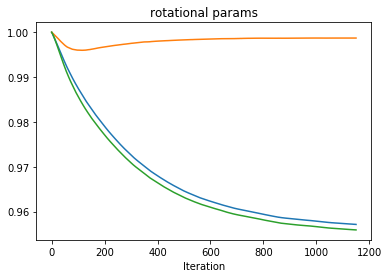

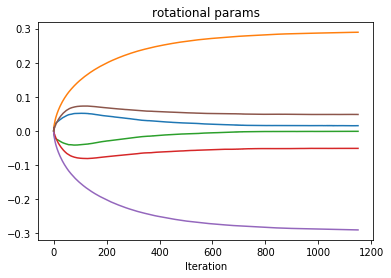

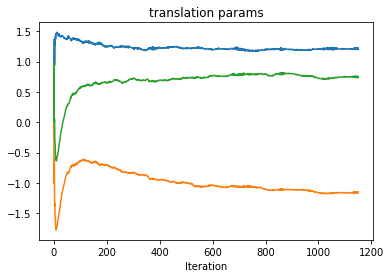

In [81]:
Ts = np.array(aligner.Ts)

plt.plot(Ts[:, [0,5,10]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [1,2,4,6,8,9]]);
plt.title('rotational params');
plt.xlabel('Iteration');
plt.show();

plt.plot(Ts[:, [3,7,11]]);
plt.title('translation params');
plt.xlabel('Iteration');
plt.show();

Best trial: 0
0.238797293652 0.23876098375
[[ 0.95988987  0.01599257  0.27992085  1.16990232]
 [-0.00155297  0.99865987 -0.05173056 -1.07183643]
 [-0.28037302  0.04922093  0.95862833  0.79604026]]


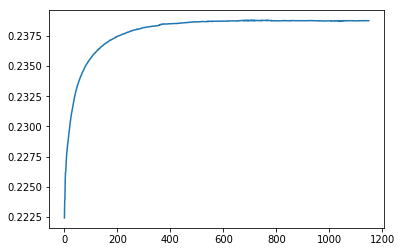

In [82]:
best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]
# best_trial = 1
T = T_all_trials[best_trial]
scores = scores_all_trials[best_trial]
print 'Best trial:', best_trial
print max(scores), scores[-1]

print T.reshape((3,4))
plt.figure();
plt.plot(scores);
plt.show();

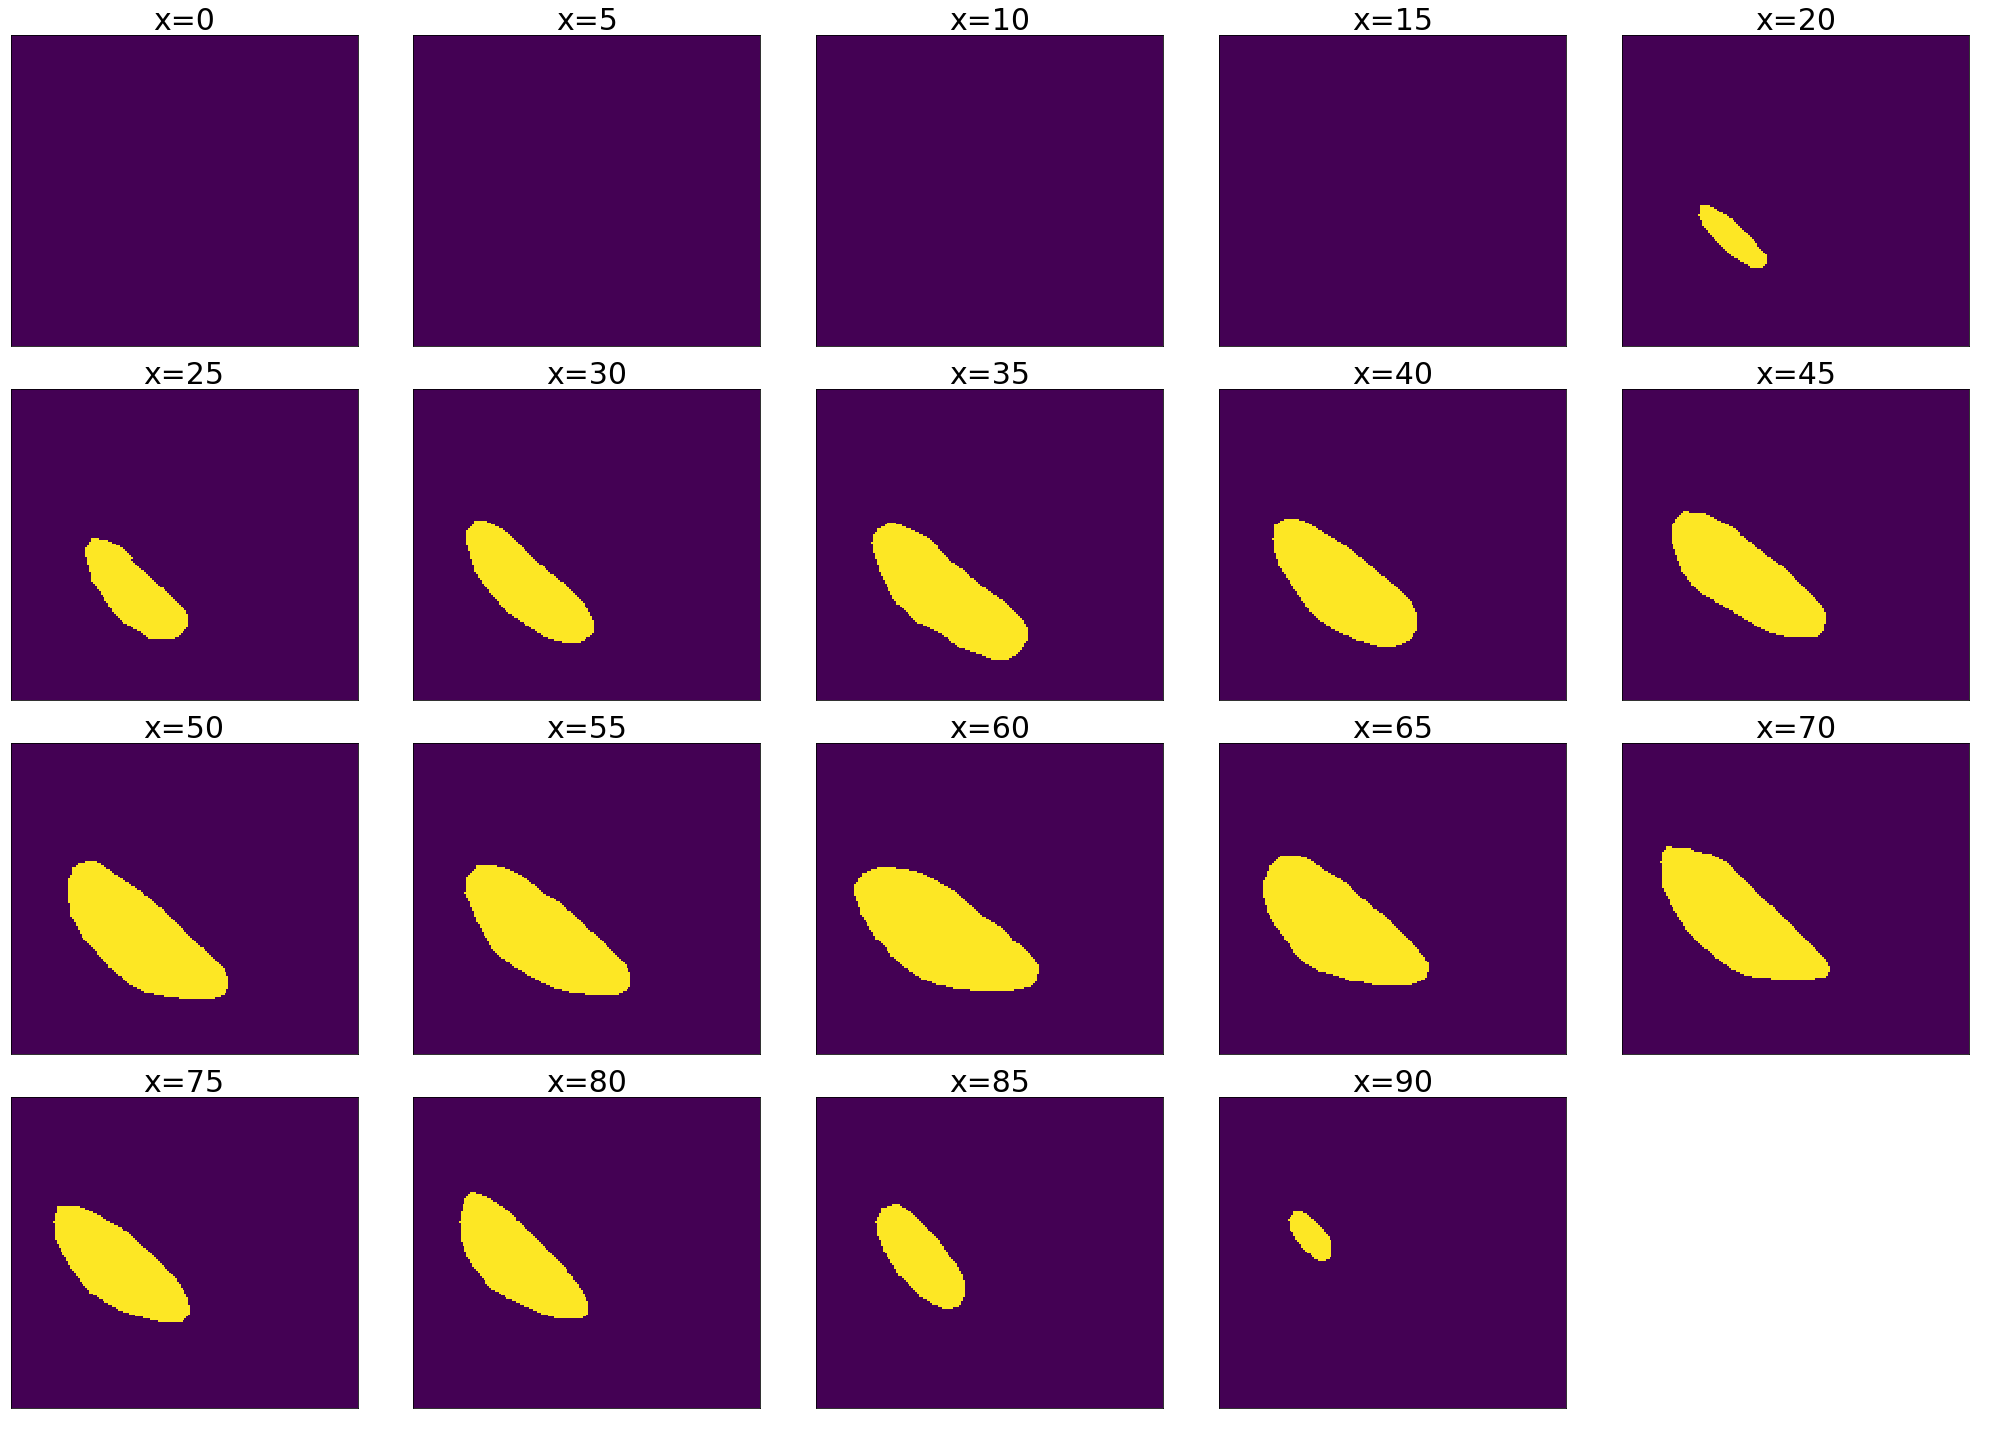

In [83]:
display_volume_sections(volume_fixed[structure_to_label_fixed[structure]], start_level=0, every=5, direction='x')

In [84]:
local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
(aligner.Ts[-1], 
  aligner.centroid_m, aligner.centroid_f,
  aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
  aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# (T, 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

# local_params, centroid_m, centroid_f, xdim_m, ydim_m, zdim_m, xdim_f, ydim_f, zdim_f = \
# ([1,0,0,0,0,1,0,0,0,0,1,0], 
#   aligner.centroid_m, aligner.centroid_f,
#   aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
#   aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)

In [88]:
# Transform moving volume, sided, without surround

# structure = '3N_L'

# vol_m = DataManager.load_original_volume(stack=stack_moving, structure=structure, downscale=32)

vol_m = volume_moving[structure_to_label_moving[structure]]

volume_m_alignedTo_f, volume_m_alignedTo_f_bbox = \
transform_volume_v2(vol=vol_m, tf_params=local_params, centroid_m=centroid_m, centroid_f=centroid_f)

In [89]:
x1f,x2f,y1f,y2f,z1f,z2f = bbox_3d(volume_fixed[structure_to_label_fixed[structure]])
sf = np.count_nonzero(volume_fixed[structure_to_label_fixed[structure]])

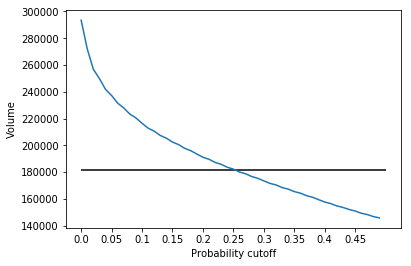

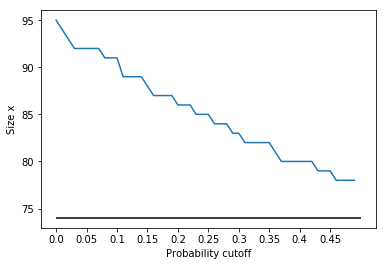

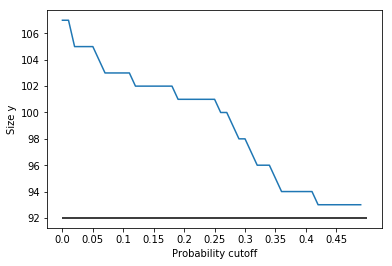

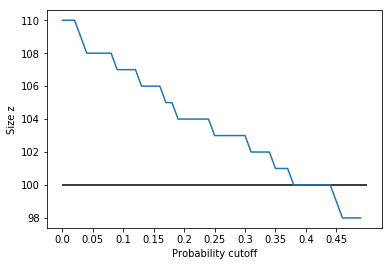

In [90]:
plt.plot([np.count_nonzero(volume_m_alignedTo_f > t) for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=sf, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Volume');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[1] - bbox_3d(volume_m_alignedTo_f > t)[0] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=x2f+1-x1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size x');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[3] - bbox_3d(volume_m_alignedTo_f > t)[2] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=y2f+1-y1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size y');
plt.show();

plt.plot([bbox_3d(volume_m_alignedTo_f > t)[5] - bbox_3d(volume_m_alignedTo_f > t)[4] 
          for t in np.arange(0.0, 0.5, 0.01)]);
plt.xticks(range(len(np.arange(0.0, 0.5, 0.01)))[::5], np.arange(0, 0.5, 0.01)[::5]);
plt.hlines(y=z2f+1-z1f, xmin=0, xmax=len(np.arange(0.0, 0.5, 0.01)));
plt.xlabel('Probability cutoff');
plt.ylabel('Size z');
plt.show();

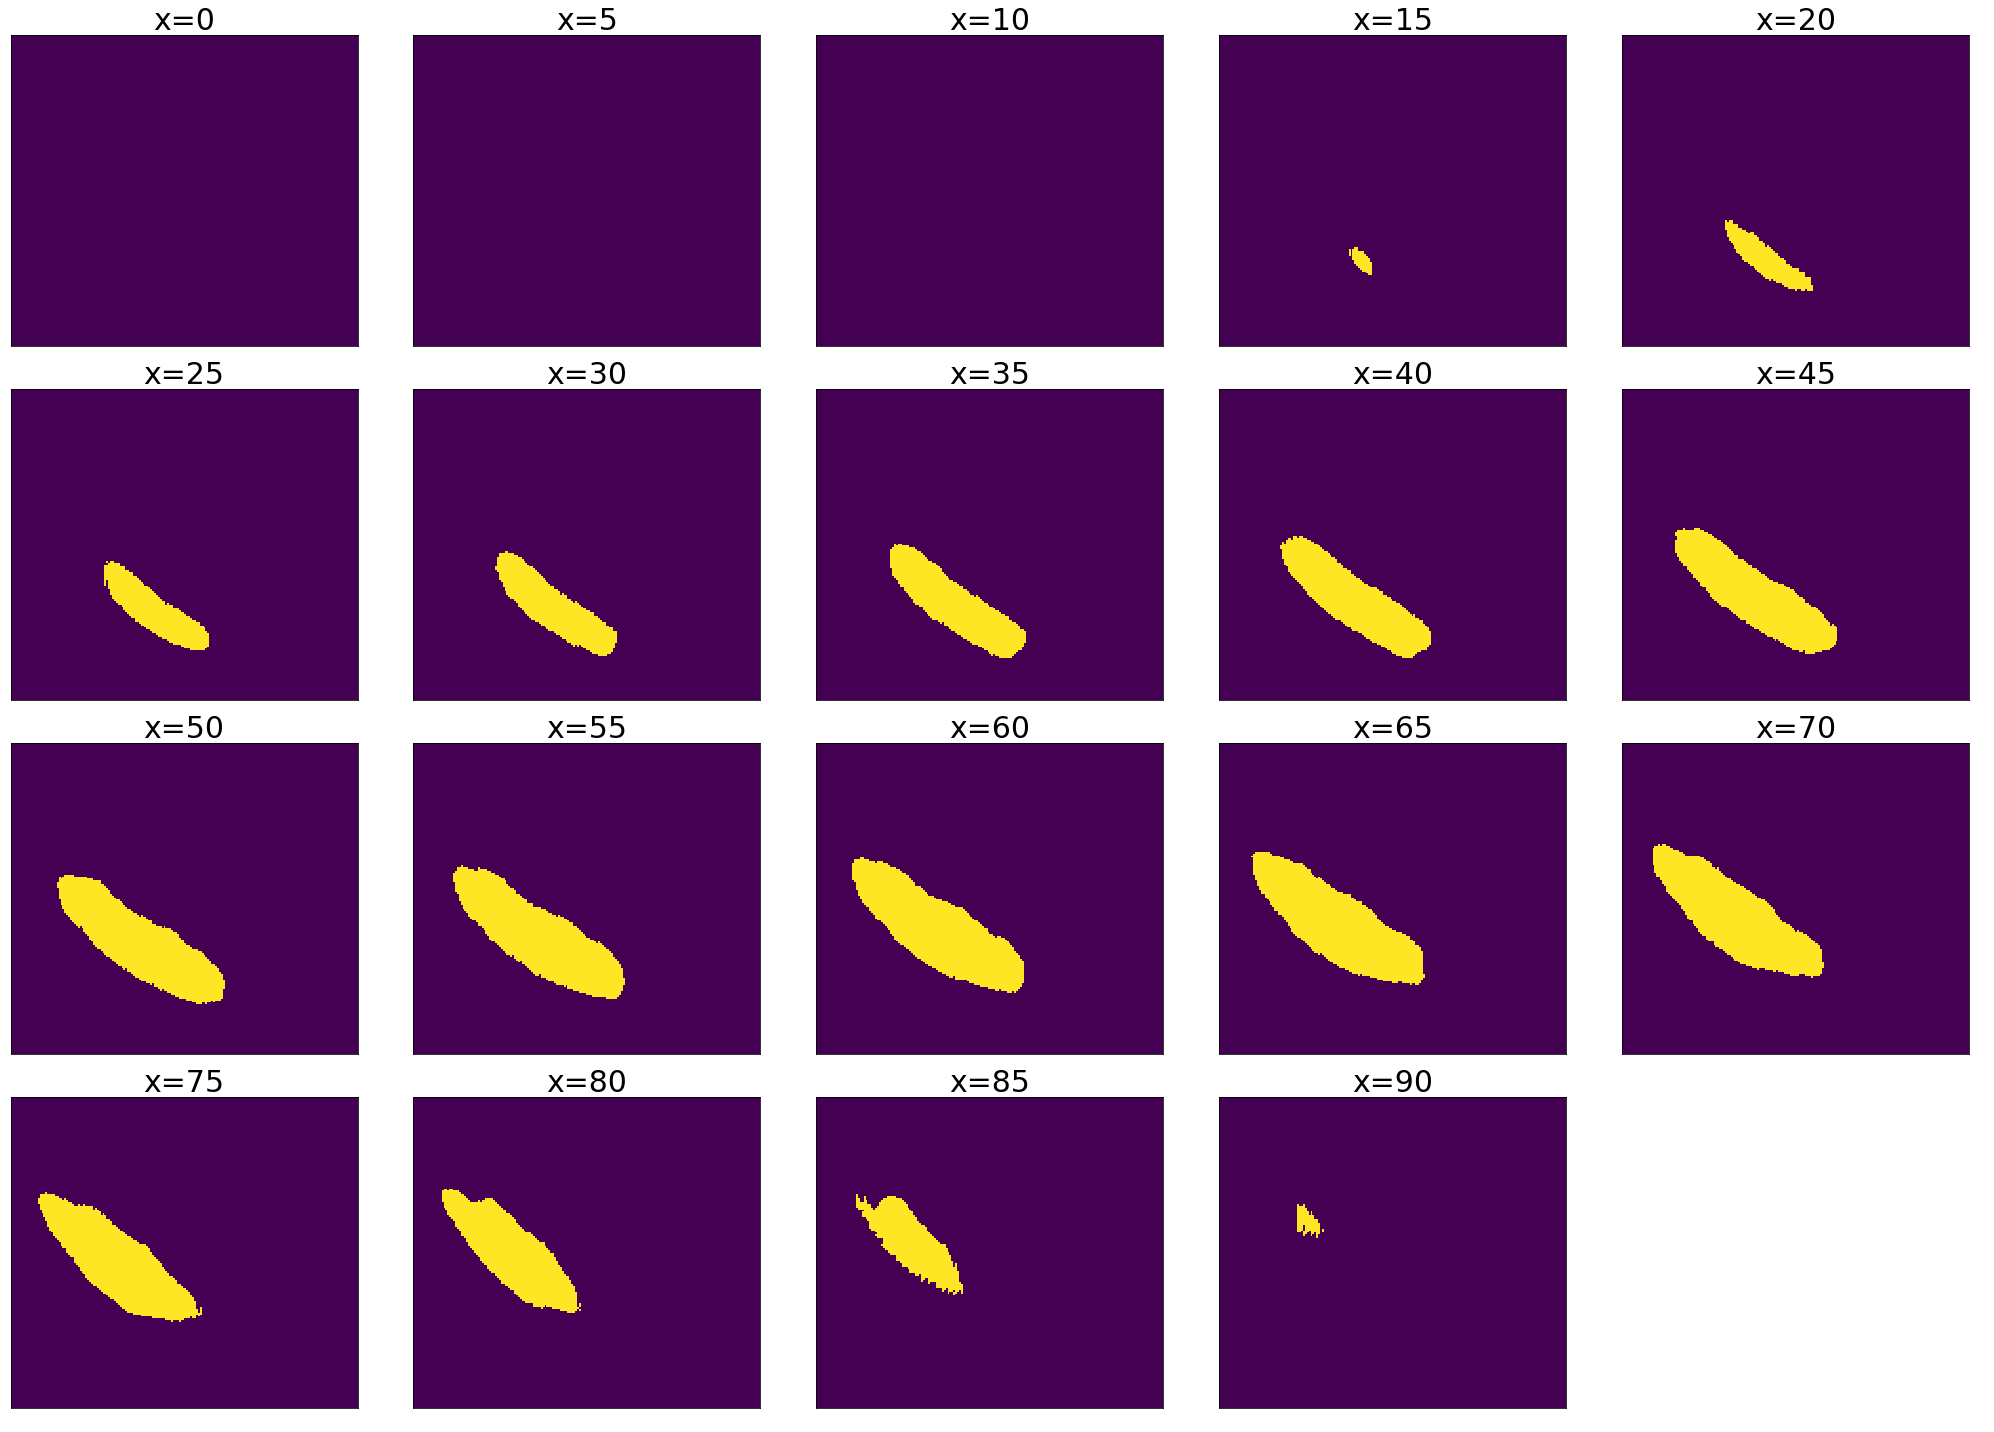

In [91]:
display_volume_sections(crop_and_pad_volume(volume_m_alignedTo_f > 0.5, in_bbox=volume_m_alignedTo_f_bbox,
                                           out_bbox=(0, xdim_f-1, 0, ydim_f-1, 0, zdim_f-1)), 
                        start_level=0,
                       direction='x')

In [92]:
#########################
# Save the best trial
#########################

best_trial = np.argsort([np.max(scores) for scores in scores_all_trials])[-1]

# Save parameters
params_fp = \
    DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                          structure_f=structure,
                                                          structure_m=structure,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='parameters')
DataManager.save_alignment_parameters(params_fp, T_all_trials[best_trial], 
                                      aligner.centroid_m, aligner.centroid_f,
                                      aligner.xdim_m, aligner.ydim_m, aligner.zdim_m, 
                                      aligner.xdim_f, aligner.ydim_f, aligner.zdim_f)
upload_to_s3(params_fp)

# Save score history
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure, 
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreHistory')
bp.pack_ndarray_file(np.array(scores_all_trials[best_trial]), history_fp)
upload_to_s3(history_fp)

# Save score plot
score_plot_fp = \
history_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                              stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                              warp_setting=warp_setting,
                                             trial_idx=None, what='scoreEvolution')
fig = plt.figure();
plt.plot(scores_all_trials[best_trial]);
plt.savefig(score_plot_fp, bbox_inches='tight')
plt.close(fig)
upload_to_s3(score_plot_fp)

# Save trajectory
trajectory_fp = DataManager.get_alignment_result_filepath(stack_m=stack_moving, 
                                                  stack_f=stack_fixed,
                                                structure_f=structure,
                                                structure_m=structure,
                                                  warp_setting=warp_setting,
                                                 trial_idx=None, what='trajectory')
bp.pack_ndarray_file(np.array(traj_all_trials[best_trial]), trajectory_fp)
upload_to_s3(trajectory_fp)

aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_parameters.txt" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_parameters.txt"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_scoreHistory.bp" "s3://mousebrainatlas-data/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32_scoreVolume_SNR_L_scoreHistory.bp"
aws s3 cp "/shared/CSHL_registration_parameters/atlasV5/atlasV5_down32_scoreVolume_SNR_L_warp22_LM40new_down32